### Peak Mem vs. Operation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
# hyperparams
batch_size = 60
model_name = "torchbenchmark.models.hf_Bert.Model"

In [60]:
# Open graph_prof.txt as a pandas dataframe
df_before = pd.read_csv(
    f"results/graph_prof_before_checkpoint_{model_name}_{batch_size}.txt"
)
df_after = pd.read_csv(
    f"results/graph_prof_after_checkpoint_{model_name}_{batch_size}.txt"
)
df_before

,Node,Node Type,Target,Size (B),Avg runtime (ms),Peak Memory (B),Parameter Memory (B),Gradient Memory (B),Activation Memory (B),Other Memory (B),Recomputation Memory (B),Swap Time (ms)
0,ones,PARAM,torch.ops.aten.ones.default,122880,0.117419,1327733248,1327610368,0,0,0,0,NaN
1,slice_1,OTHER,torch.ops.aten.slice.Tensor,4096,0.056320,1327733248,1327610368,0,0,4096,0,NaN
2,expand,ACT,torch.ops.aten.expand.default,4096,0.045397,1327733248,1327610368,0,4096,4096,0,0.065024
3,slice_2,PARAM,torch.ops.aten.slice.Tensor,122880,0.029355,1327733248,1327610368,0,4096,0,0,NaN
4,unsqueeze,PARAM,torch.ops.aten.unsqueeze.default,122880,0.037888,1327733248,1327610368,0,4096,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4126,copy__812,OTHER,torch.ops.aten.copy_.default,3072,0.042667,1421502464,1327610368,0,0,1408164864,0,NaN
4127,copy__813,OTHER,torch.ops.aten.copy_.default,3072,0.042325,1421499392,1327610368,0,0,1408164864,0,NaN
4128,copy__814,OTHER,torch.ops.aten.copy_.default,93763584,0.145408,1421496320,1327610368,0,0,1501925376,0,NaN
4129,copy__815,OTHER,torch.ops.aten.copy_.default,122368,0.044715,1327732736,1327610368,0,0,1314520576,0,NaN


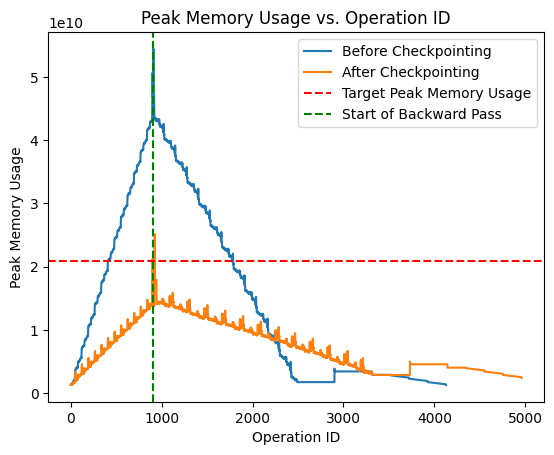

In [61]:
# PLOT BOTH DFs ON THE SAME PLOT
plt.plot(df_before["Peak Memory (B)"], label="Before Checkpointing")
plt.plot(df_after["Peak Memory (B)"], label="After Checkpointing")

# Plot target peak memory usage
plt.axhline(20937965568, color="red", linestyle="--", label="Target Peak Memory Usage")
# Plot start of backward pass
sep_backward_idx = df_before[df_before["Node"] == "sep_backward"].index[0]
plt.axvline(
    sep_backward_idx, color="green", linestyle="--", label="Start of Backward Pass"
)

# Plot memory usage by type of node


plt.xlabel("Operation ID")
plt.ylabel("Peak Memory Usage")
plt.title("Peak Memory Usage vs. Operation ID")
plt.legend()

plt.show()


### Before vs. After Peak Mem

In [63]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
# Go through all the files in the results folder with the format results_*.csv
# and concatenate them into a single dataframe
df = None
for file in os.listdir("results"):
    if file.endswith(".csv") and file.startswith("results_"):
        # Open the file as a pandas dataframe
        row_df = pd.read_csv(os.path.join("results", file))
        if df is None:
            df = row_df
        else:
            df = pd.concat([df, row_df])
df = df.reset_index()

# Group by Model and Batch Size and get the mean of the other two columns
df = df.groupby(["Model", "Batch Size"]).mean().reset_index()
df

,Model,Batch Size,index,Run Time,Peak Memory
0,Resnet18,1,0.0,7.178581,3.906330e+08
1,Resnet18,4,0.0,7.345835,3.948477e+08
2,Resnet18,8,0.0,7.579989,3.950116e+08
3,Resnet18,32,0.0,15.725227,8.988109e+08
4,Resnet18,128,0.0,46.378325,3.062418e+09
5,Resnet18,256,0.0,88.921430,5.942857e+09
6,Resnet18,500,0.0,169.470464,1.143046e+10
7,Resnet18,512,0.0,173.202098,1.169430e+10
8,Resnet18,750,0.0,251.368103,1.704908e+10
9,Resnet18,1000,0.0,335.442774,2.196011e+10


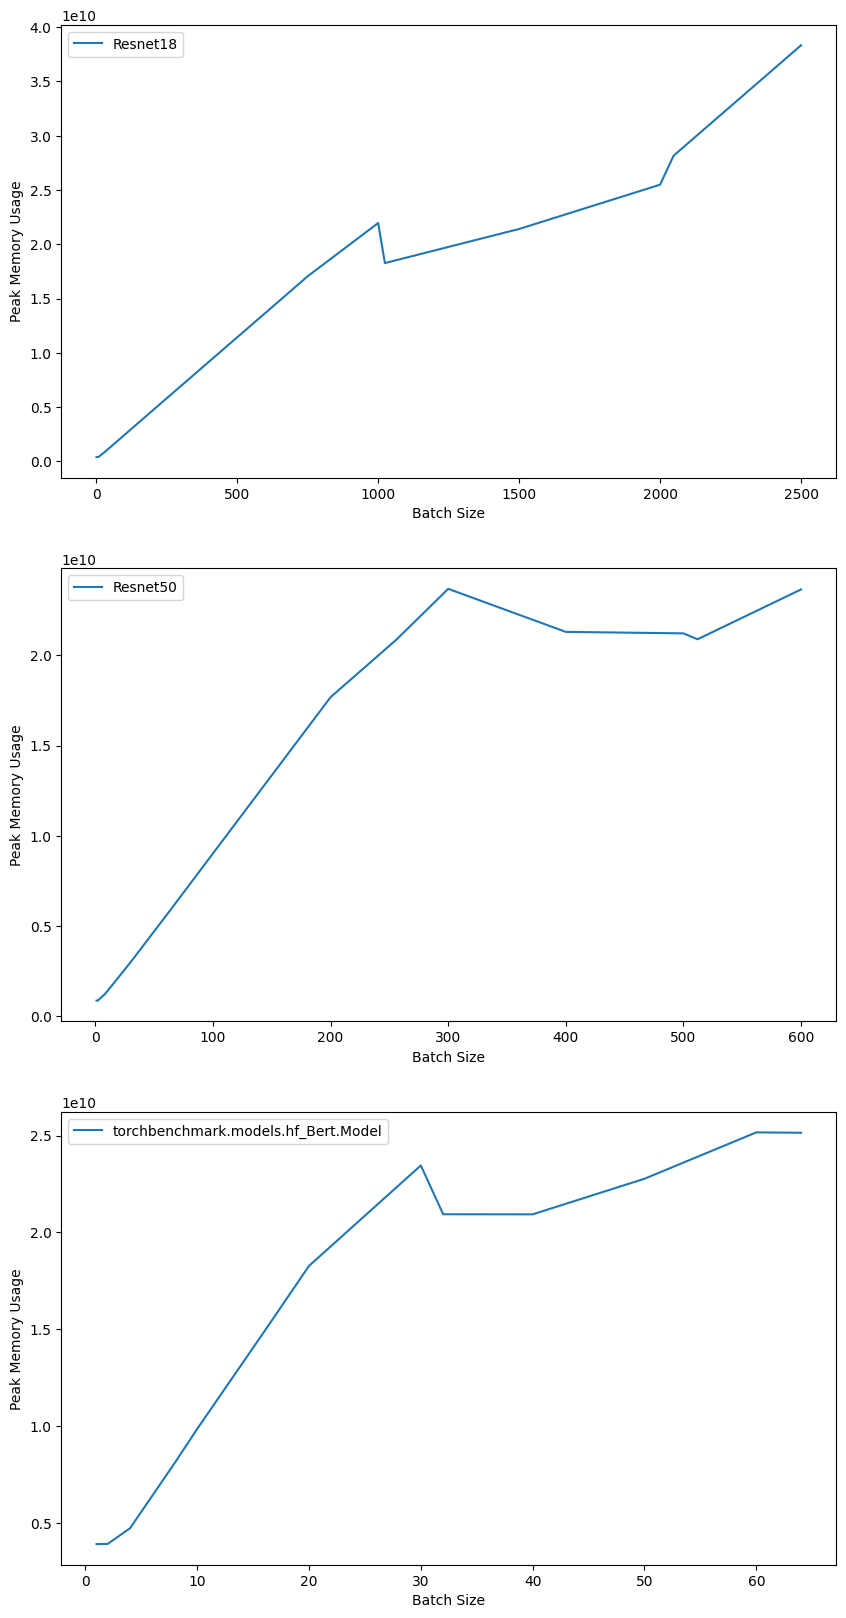

In [ ]:
# Plot the peak memory usage vs. batch size for each model
# Put each model in a different subplot
assert df is not None
fig, axes = plt.subplots(nrows=1, ncols=len(df["Model"].unique()), figsize=(10, 30))
for i, model in enumerate(df["Model"].unique()):
    axes[i].plot(
        df[df["Model"] == model]["Batch Size"],
        df[df["Model"] == model]["Peak Memory"],
        label=model,
    )
    axes[i].set_xlabel("Batch Size")
    axes[i].set_ylabel("Peak Memory Usage")
    axes[i].legend()
